In [2]:
import tqdm
import os
import pprint
import numpy as np
import torch
from torch.optim import Adam
import torch.nn.functional as F
from util import *
from model import HeteroVGAE
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
	torch.set_default_tensor_type('torch.cuda.FloatTensor')

fix_seed()

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
graph = load_binary('/app/data/bipartite_graph.pkl')
num_company:int = len({n for n, d in graph.nodes(data=True) if d["bipartite"] == 'company'})
company:list = list(graph.nodes)[:num_company]
term:list = list(graph.nodes)[num_company:]

### データの読み込み

In [4]:
# load data
patent_company = load_binary('/app/data/patent_company.pkl')
patent_term = load_binary('/app/data/patent_term.pkl')
cpc = clamp(torch.matmul(patent_company.T, patent_company), 0, 1).to('cpu')
cpt = clamp(torch.matmul(patent_company.T, patent_term), 0, 1).to('cpu')

### コラボしたい企業のインデックスと熊谷組自身のインデックスの取得

In [5]:
# want to collaborate with these companies
# target_company_list:list = ['株式会社熊谷組', '大成建設株式会社', '鹿島建設株式会社', '清水建設株式会社', '株式会社大林組', 'ＤＸアンテナ株式会社']
target_company_list:list = ['清水建設株式会社']
# target_company_list:list = ['鹿島建設株式会社']
# target_company_list:list = ['ＤＸアンテナ株式会社']
# target_company_list:list = ['トヨタ自動車株式会社']
target_company_list.append('株式会社熊谷組')
# target_company_list:list = ['株式会社熊谷組', 'ＤＸアンテナ株式会社']
target_company_index:int = [company.index(c) for c in target_company_list]

# 熊谷組's index 
target_company = company.index('株式会社熊谷組')

In [6]:
target_company_index

[16, 28]

### 特徴量などの作成

In [7]:
# prepare for prediction
# cpc_prediction = create_prediction_tensor(target_company_index, cpc)
cpc_prediction = cpc
cpc_norm = normalize_adj(csr_matrix(cpc_prediction.cpu().detach().numpy()))
# cpt_prediction = create_prediction_tensor(target_company_index, cpt).T
cpt_prediction = cpt.T
# cpt_norm = normalize_adj(csr_matrix(cpt_prediction.cpu().detach().numpy()), flag=False)

# feature = create_feature_for_prediction(cpc.shape[1], target_company_index)
feature = create_feature(cpc.shape[1])
feature = prepare_features_for_training(feature)

input_dim = feature.shape[1]
bipartite_dim = cpt_prediction.shape[1]

# cpc_prediction = cpc_prediction.to(device)
# cpt_prediction = cpt_prediction.to(device)
feature = feature.to(device)
dropout = 0.0
cpc_norm = cpc_norm.to(device)
# cpt_norm = cpt_norm.to(device).T
cpt_norm = cpt_prediction.to(device)

[[148.]
 [ 12.]
 [259.]
 ...
 [  2.]
 [  2.]
 [  3.]]


### Start Prediction ...

In [8]:
model = HeteroVGAE(input_dim, bipartite_dim, hidden1_dim=4, hidden2_dim=2, dropout=dropout)
model.load_state_dict(torch.load('/app/model/model-4.pt'))

<All keys matched successfully>

In [9]:
model.eval()
model = model.to(device)
with torch.no_grad():
    # z_c, z_t = model.predict(feature, cpc_prediction, cpt_prediction)
    z_c, z_t = model.predict(feature, cpc_norm, cpt_norm)

print(z_c[target_company_index, :])

tensor([[ 2.9656, -0.0427],
        [ 2.8694, -0.0311]])


In [10]:
z_c

tensor([[ 2.0994, -0.1099],
        [ 0.6357, -0.0105],
        [ 2.5633, -0.0768],
        ...,
        [ 0.4016, -0.0066],
        [ 0.2478,  0.0060],
        [ 0.2263,  0.0094]])

In [11]:
z_t

tensor([[20.6310,  3.1600],
        [-0.4374, 13.0564],
        [-0.2396,  7.6139],
        ...,
        [ 1.2682,  0.1877],
        [ 1.2682,  0.1877],
        [ 1.2682,  0.1877]])

In [12]:
recommended_items_idx = recommendable_items(z_c, z_t, target_company, 100)
recommended_items = [term[i] for i in recommended_items_idx]

### Plot Latent Space

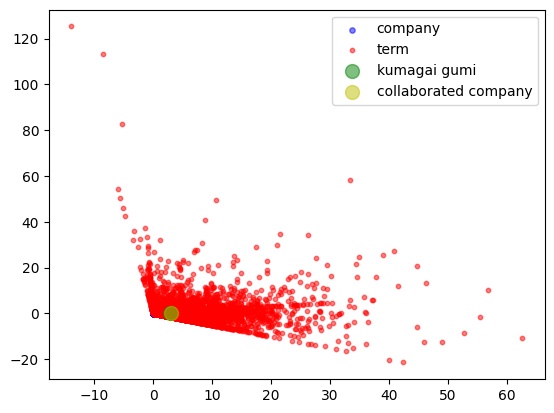

In [13]:
# plot
plt.scatter(z_c[:, 0].cpu().numpy(), z_c[:, 1].cpu().numpy(), c='b', s=15, alpha=0.5, label='company')
plt.scatter(z_t[:, 0].cpu().numpy(), z_t[:, 1].cpu().numpy(), c='r', s=10, alpha=0.5, label='term')
plt.scatter(z_c[target_company_index[-1], 0].cpu().numpy(), z_c[target_company_index[-1], 1].cpu().numpy(), c='g', s=100, alpha=0.5, label='kumagai gumi')
plt.scatter(z_c[target_company_index[0], 0].cpu().numpy(), z_c[target_company_index[0], 1].cpu().numpy(), c='y', s=100, alpha=0.5, label='collaborated company')
plt.legend(loc='best', fontsize=10)

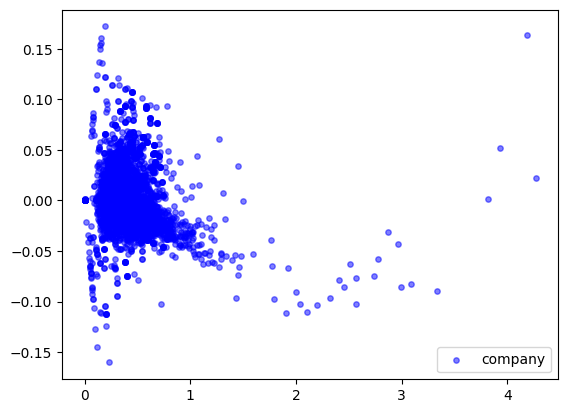

In [14]:
# plot
plt.scatter(z_c[:, 0].cpu().numpy(), z_c[:, 1].cpu().numpy(), c='b', s=15, alpha=0.5, label='company')

plt.legend(loc='best', fontsize=10)

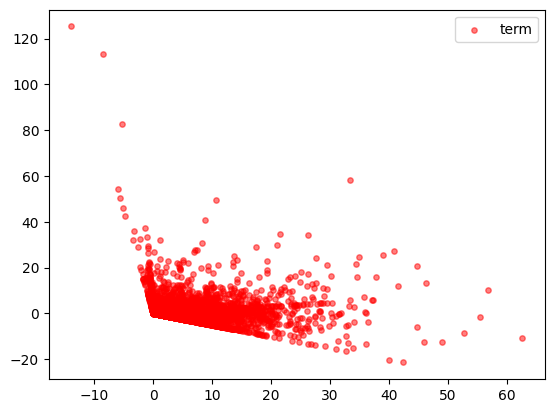

In [28]:
# plot
plt.scatter(z_t[:, 0].cpu().numpy(), z_t[:, 1].cpu().numpy(), c='r', s=15, alpha=0.5, label='term')

plt.legend(loc='best', fontsize=10)

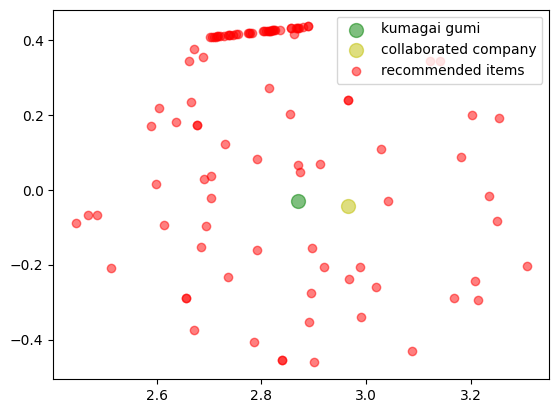

In [15]:
recommended_items_x = z_t[recommended_items_idx, 0].to('cpu').detach().numpy()
recommended_items_y = z_t[recommended_items_idx, 1].to('cpu').detach().numpy()
target_company_x = z_c[target_company_index, 0].to('cpu').detach().numpy()
target_company_y = z_c[target_company_index, 1].to('cpu').detach().numpy()

plt.scatter(z_c[target_company_index[-1], 0].cpu().numpy(), z_c[target_company_index[-1], 1].cpu().numpy(), c='g', s=100, alpha=0.5, label='kumagai gumi')
plt.scatter(z_c[target_company_index[0], 0].cpu().numpy(), z_c[target_company_index[0], 1].cpu().numpy(), c='y', s=100, alpha=0.5, label='collaborated company')
plt.scatter(recommended_items_x, recommended_items_y, c='red', alpha=0.5, label='recommended items')
# plt.scatter(target_company_x, target_company_y, c='red', alpha=0.5, label='target company')
plt.legend(loc='best', fontsize=10)

### 対象企業が保有している技術の確認

In [16]:
kumagai_term = [term[i] for i in range(len(term)) if cpt[target_company, i] == 1]

# validation

In [17]:
# 清水建設が保有している技術の確認
shimizu = target_company_index[0]
simizu_term = [term[i] for i in range(len(term)) if cpt[shimizu, i] == 1]

In [18]:
def eval(term1, companyIndex, recommendable_items):

    term2 = [term[i] for i in range(len(term)) if cpt[companyIndex, i] == 1]

    # recommendable_itemsの中で，term1とterm2の両方に含まれる割合を抽出
    term1_index = [i for i in range(len(term)) if term[i] in term1]
    term2_index = [i for i in range(len(term)) if term[i] in term2]
    recommendable_items_index = [i for i in range(len(term)) if term[i] in recommendable_items]
    term1_and_term2 = [i for i in recommendable_items_index if i in term1_index and i in term2_index]
    cover = len(term1_and_term2) / len(recommendable_items_index)

    # recommendable_itemsの中で，term1に含まれ，term2に含まれない割合を抽出
    term1_not_term2 = [i for i in recommendable_items_index if i in term1_index and i not in term2_index]
    term1_not_term2_term_list = [term[i] for i in term1_not_term2]
    cover_not_term2 = len(term1_not_term2) / len(recommendable_items_index)

    # recommendable_itemsの中で，term1には含まれず，term2に含まれる割合を抽出
    not_term1_term2 = [i for i in recommendable_items_index if i not in term1_index and i in term2_index]
    not_term1_term2_term_list = [term[i] for i in not_term1_term2]
    cover_not_term1 = len(not_term1_term2) / len(recommendable_items_index)
    
    # recommendable_itemsの中で，term1には含まれず，term2にも含まれない割合を抽出
    not_term1_not_term2 = [i for i in recommendable_items_index if i not in term1_index and i not in term2_index]
    not_term1_not_term2_term_list = [term[i] for i in not_term1_not_term2]
    cover_not_term1_not_term2 = len(not_term1_not_term2) / len(recommendable_items_index)

    return cover, cover_not_term2, cover_not_term1, cover_not_term1_not_term2, term1_not_term2_term_list, not_term1_term2_term_list, not_term1_not_term2_term_list

In [19]:
cover, cover_not_term2, cover_not_term1, cover_not_term1_not_term2, term1_not_term2_term_list, not_term1_term2_term_list, not_term1_not_term2_term_list = eval(kumagai_term, target_company_index[0], recommended_items)

In [20]:
cover

0.27

In [21]:
cover_not_term1

0.48

In [22]:
not_term1_term2_term_list

['押出装置',
 '低温空気',
 '液状化防止構造',
 '根固めブロック',
 '直立壁',
 '六角穴付ボルト',
 '補強鋼管',
 'ラップ部分',
 '伸縮脚',
 '排気機構',
 '造成地盤',
 'ビス孔',
 '空気抜きパイプ',
 'チャック装置',
 '操作部材',
 '上段足場',
 'ドアノブ',
 'シール本体',
 '補強フレーム',
 '穿孔用ロッド',
 '設置プレート',
 '位置決めプレート',
 'ダクト本体',
 'フレームユニット',
 '字部材',
 '下段足場',
 '送水パイプ',
 '印加電極',
 '地盤改良杭',
 '分岐線トンネル',
 '撹拌ロッド',
 '再生ヒータ',
 'フェールセーフ機構',
 'オス継手',
 'モバイル端末',
 'サーバシステム',
 'プレテンション導入装置',
 '撹拌機構',
 '覗き窓',
 '外気ダクト',
 '既設水路',
 '外主桁',
 '回収配管',
 '可動質量',
 '水平ダンパー',
 '灌水チューブ',
 '測位衛星',
 '域センサ']

In [23]:
cover_not_term2

0.02

In [24]:
term1_not_term2_term_list

['造成装置', '吊手段']

In [25]:
cover_not_term1_not_term2

0.23

In [26]:
not_term1_not_term2_term_list

['集水部材',
 'カッタードラム',
 '沈水植物',
 '梁柱架構',
 '補強部材本体',
 '電極セレクタ',
 '吸着部材',
 '無線通信端末',
 '油水分離装置',
 'メタン精製設備',
 '板状羽根',
 '可動破砕腕',
 '固定破砕腕',
 '上側梁主筋',
 '下側梁主筋',
 '弾性伸縮部材',
 'プラグ部材',
 '駆動用スプロケット',
 'シアン化合物汚染土壌',
 '既設梁柱架構',
 'プレテンション部材',
 'セラミックスボルト',
 '河口堰']